# <span style="font-size:36px; color:orange;">Pair Trading Model⬇️ </span>

[*********************100%***********************]  2 of 2 completed


✅ Johansen test: GOOG & MSFT appear cointegrated.
✅ Hedge Ratio: 0.7513

--- Optimization Results ---
Grid Search Best Params: (90, 30, 0.2, 0.5, 0.1, 0.08, 1.5), Cost: -0.68
Random Search Best Params: (60, 37, 0.1658693631618945, 0.37220082031107227, 0.0535284373700215, 0.12496934947444209, 1.5397669658124327), Cost: 999.83
Bayesian Optimization Best Params: (61, 39, 0.18656322312112822, 0.5326302867754906, 0.0827880150215764, 0.14401495104184592, 2.323477820045084), Cost: -0.45

--- Selected Parameter Set ---
Rolling Window: 90 days
Quantile Window: 30 days
Exit Threshold: 0.2
ATR Multiplier: 0.5
Max Drawdown Limit: 10.0%
Target Annual Volatility: 0.08
Max Leverage: 1.5
Selected Cost (objective): -0.68


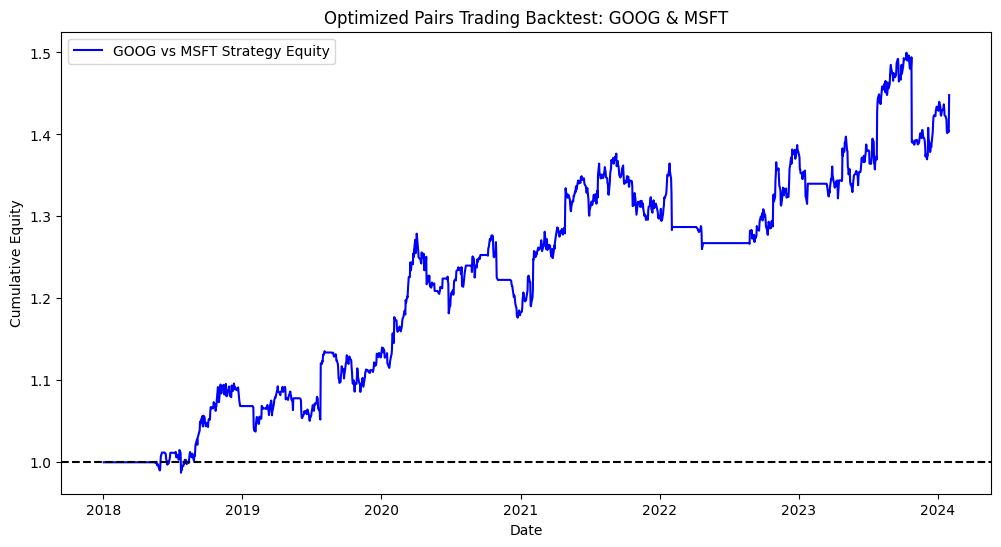


--- Final Performance ---
Rolling Window: 90 days
Quantile Window: 30 days
Exit Threshold: 0.2
ATR Multiplier: 0.5
Max Drawdown Limit: 10.0%
Target Annual Volatility: 0.08
Max Leverage: 1.5
Total Return: 44.80%
Annualized Return: 6.27%
Annualized Volatility: 9.21%
Sharpe Ratio: 0.68
Sortino Ratio: 0.78
Max Drawdown: -8.67%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. SETTINGS & DATA DOWNLOAD
# =============================================================================
np.random.seed(42)

# Define tickers for a potentially cointegrated pair.
ticker1 = "GOOG"
ticker2 = "MSFT"
tickers = [ticker1, ticker2]

start_date = "2018-01-01"
end_date   = "2024-02-01"

# Transaction cost parameters
slippage   = 0.0005  # 0.05%
commission = 0.0002  # 0.02%
cost_per_trade = slippage + commission

def download_data(tickers, start_date, end_date):
    # Download OHLC data with auto_adjust=False so that 'Adj Close' is available
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
    if data.empty:
        raise ValueError("No data downloaded. Check tickers or date range.")
    return data

data = download_data(tickers, start_date, end_date)
df_adj = data['Adj Close'].dropna()  # Adjusted Close prices
log_df = np.log(df_adj)

# =============================================================================
# 2. ATR CALCULATION (for stop-loss)
# =============================================================================
def compute_atr(high, low, close, window=14):
    tr = pd.concat([high - low,
                    (high - close.shift(1)).abs(),
                    (low - close.shift(1)).abs()], axis=1).max(axis=1)
    return tr.rolling(window).mean()

# Calculate ATR (in price terms) for each ticker, then take the average.
atr1 = compute_atr(data['High'][ticker1], data['Low'][ticker1], data['Close'][ticker1], window=14)
atr2 = compute_atr(data['High'][ticker2], data['Low'][ticker2], data['Close'][ticker2], window=14)
avg_atr = (atr1 + atr2) / 2

# Convert ATR to a percentage measure using the overall average price.
avg_price = df_adj.mean().mean()
global_atr_pct = avg_atr.mean() / avg_price

# =============================================================================
# 3. COINTEGRATION & HEDGE RATIO
# =============================================================================
def johansen_test(log_prices):
    result = coint_johansen(log_prices, det_order=-1, k_ar_diff=1)
    # Compare the trace statistic with the 5% critical value
    return result.lr1[0] > result.cvt[0, 1]

if johansen_test(log_df[[ticker1, ticker2]]):
    print(f"✅ Johansen test: {ticker1} & {ticker2} appear cointegrated.")
else:
    print(f"⚠️ Johansen test: {ticker1} & {ticker2} may NOT be cointegrated. (Continuing anyway...)")

def compute_hedge_ratio(log_prices, tkrA, tkrB):
    # Regress log_prices[tkrA] on log_prices[tkrB]
    return sm.OLS(log_prices[tkrA], sm.add_constant(log_prices[tkrB])).fit().params[tkrB]

hedge_ratio = compute_hedge_ratio(log_df, ticker1, ticker2)
print(f"✅ Hedge Ratio: {hedge_ratio:.4f}")

def compute_spread(log_prices, tkrA, tkrB, hr):
    return log_prices[tkrA] - hr * log_prices[tkrB]

spread = compute_spread(log_df, ticker1, ticker2, hedge_ratio)

# =============================================================================
# 4. STRATEGY SIMULATION FUNCTION WITH DYNAMIC LEVERAGE & VOLATILITY FILTER
# =============================================================================
def simulate_strategy(df_prices, spread, hedge_ratio, rolling_window, quantile_window,
                      exit_threshold, atr_multiplier, max_drawdown_limit,
                      cost_per_trade, target_vol, max_leverage):
    """
    Parameters:
      - rolling_window: period for rolling mean/std of spread.
      - quantile_window: period for adaptive quantile thresholds.
      - exit_threshold: exit signal threshold for z-score.
      - atr_multiplier: multiplier for ATR stop-loss (as a pct).
      - max_drawdown_limit: overall drawdown limit.
      - cost_per_trade: transaction cost per trade.
      - target_vol: target annualized volatility for dynamic leverage (e.g., 0.10 for 10%).
      - max_leverage: maximum allowable dynamic leverage.
    """
    # 1) Compute rolling statistics and z-score for the spread.
    roll_mean = spread.rolling(rolling_window).mean()
    roll_std  = spread.rolling(rolling_window).std()
    z_score   = (spread - roll_mean) / roll_std

    # 2) Calculate adaptive thresholds using rolling quantiles.
    upper_q = z_score.rolling(quantile_window).quantile(0.75).bfill()
    lower_q = z_score.rolling(quantile_window).quantile(0.25).bfill()

    # 3) Compute ATR-based stop-loss threshold (converted to percentage terms).
    atr_stop_loss = atr_multiplier * global_atr_pct

    # 4) Compute overall market volatility (average of daily % changes for both tickers)
    overall_vol = df_prices.pct_change().rolling(21).std().mean(axis=1)
    vol_filter_threshold = 0.02  # e.g. skip new trades if daily volatility >2%

    # 5) Pre-calculate dynamic leverage:
    #    Compute the target daily volatility (annual target divided by sqrt(252))
    target_daily_vol = target_vol / np.sqrt(252)
    asset_returns = df_prices.pct_change().fillna(0)
    # Daily spread return = difference between ticker returns (adjusted by hedge ratio)
    daily_spread_ret_series = asset_returns[ticker1] - hedge_ratio * asset_returns[ticker2]
    # Rolling volatility of spread returns over 30 days.
    rolling_spread_std = daily_spread_ret_series.rolling(30, min_periods=30).std().bfill()
    # Dynamic leverage: scale such that daily volatility is targeted.
    dynamic_leverage = (target_daily_vol / rolling_spread_std).clip(0.5, max_leverage)

    dates = df_prices.index
    n = len(dates)

    positions = np.zeros(n)    # +1 for long spread, -1 for short spread, 0 for flat.
    pos_sizes = np.zeros(n)    # Dynamic, volatility-adjusted position sizes.
    strat_returns = np.zeros(n)
    equity_curve = np.zeros(n)

    equity = 1.0
    equity_curve[0] = equity
    current_pos = 0
    current_max = equity

    # Track each trade's entry equity for trade-specific stop-loss.
    entry_equity = None

    for i in range(1, n):
        # Update running maximum equity (for overall drawdown control).
        current_max = max(current_max, equity_curve[i-1])
        if equity_curve[i-1] < (1 - max_drawdown_limit) * current_max:
            current_pos = 0
            entry_equity = None

        # Signal Generation & Risk Management:
        # Do not open a new position if overall market volatility is above the threshold.
        if current_pos == 0:
            if overall_vol.iloc[i] > vol_filter_threshold:
                new_pos = 0  # Skip entry during high volatility regime.
            else:
                if z_score.iloc[i] < lower_q.iloc[i]:
                    new_pos = 1  # Enter long spread.
                    entry_equity = equity
                elif z_score.iloc[i] > upper_q.iloc[i]:
                    new_pos = -1 # Enter short spread.
                    entry_equity = equity
                else:
                    new_pos = 0
        else:
            # When in position, check trade-specific stop-loss.
            if entry_equity is not None and equity < entry_equity * (1 - atr_stop_loss):
                new_pos = 0  # Exit trade due to stop-loss trigger.
                entry_equity = None
            else:
                # Maintain the current position if the z-score has not reversed sufficiently.
                new_pos = current_pos if abs(z_score.iloc[i]) >= exit_threshold else 0
                if new_pos == 0:
                    entry_equity = None

        # Transaction cost incurred on any change in position.
        transaction_cost = cost_per_trade * abs(new_pos - current_pos)
        positions[i] = new_pos
        # Use dynamic leverage as the position size factor.
        pos_sizes[i] = new_pos * dynamic_leverage.iloc[i]

        # Compute the daily spread return from previous day's position.
        daily_spread_ret = asset_returns[ticker1].iloc[i] - hedge_ratio * asset_returns[ticker2].iloc[i]
        daily_strat_ret = pos_sizes[i-1] * daily_spread_ret - transaction_cost

        equity *= (1 + daily_strat_ret)
        equity_curve[i] = equity
        strat_returns[i] = daily_strat_ret

        current_pos = new_pos

    equity_curve = pd.Series(equity_curve, index=dates)
    strat_returns = pd.Series(strat_returns, index=dates)

    # Compute performance metrics.
    total_return = equity_curve.iloc[-1] - 1
    days = (dates[-1] - dates[0]).days
    annualized_return = (equity_curve.iloc[-1]) ** (365.0 / days) - 1 if days > 30 else np.nan
    equity_daily_ret = equity_curve.pct_change().fillna(0)
    ann_vol = equity_daily_ret.std() * np.sqrt(252)
    sharpe = annualized_return / ann_vol if ann_vol > 0 else np.nan
    downside_vol = equity_daily_ret[equity_daily_ret < 0].std() * np.sqrt(252)
    sortino = annualized_return / downside_vol if downside_vol > 0 else np.nan
    dd_series = equity_curve / equity_curve.cummax() - 1
    max_dd = dd_series.min()

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_vol': ann_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_dd
    }
    
    return equity_curve, strat_returns, positions, metrics

# =============================================================================
# 5. OBJECTIVE FUNCTION FOR OPTIMIZATION
# =============================================================================
def objective(params):
    """
    Parameters to optimize (7 total):
      rw: rolling_window
      qw: quantile_window
      et: exit_threshold
      am: atr_multiplier
      dl: max_drawdown_limit
      tv: target annual volatility (for dynamic leverage)
      ml: max_leverage
    """
    rw, qw, et, am, dl, tv, ml = params
    eq_curve, _, _, metrics = simulate_strategy(
        df_prices=df_adj,
        spread=spread,
        hedge_ratio=hedge_ratio,
        rolling_window=rw,
        quantile_window=qw,
        exit_threshold=et,
        atr_multiplier=am,
        max_drawdown_limit=dl,
        cost_per_trade=cost_per_trade,
        target_vol=tv,
        max_leverage=ml
    )
    sharpe = metrics['sharpe_ratio']
    total_ret = metrics['total_return']
    # Apply a heavy penalty if total return is less than 20%
    cost = -sharpe if total_ret >= 0.20 else -sharpe + 1000
    return cost

# =============================================================================
# 6. OPTIMIZATION METHODS
# =============================================================================
from itertools import product
from skopt import gp_minimize

# (A) Grid Search
def grid_search():
    # Define grids for the 7 parameters
    rolling_windows   = [30, 60, 90]
    quantile_windows  = [20, 30, 40]
    exit_thresholds   = [0.1, 0.15, 0.2]
    atr_multipliers   = [0.25, 0.5, 1.0]
    drawdown_limits   = [0.05, 0.1]
    target_vols       = [0.08, 0.10, 0.12]   # annualized target volatility (8%-12%)
    max_leverages     = [1.5, 2.0, 3.0]
    
    best_cost = float('inf')
    best_params = None
    for params in product(rolling_windows, quantile_windows, exit_thresholds,
                          atr_multipliers, drawdown_limits, target_vols, max_leverages):
        cost = objective(params)
        if cost < best_cost:
            best_cost = cost
            best_params = params
    return best_params, best_cost

# (B) Random Search
def random_search(n_iter=50):
    bounds = [(30, 90),      # rolling_window
              (20, 40),      # quantile_window
              (0.1, 0.2),    # exit_threshold
              (0.25, 1.0),   # atr_multiplier
              (0.05, 0.1),   # max_drawdown_limit
              (0.08, 0.15),  # target_vol
              (1.5, 3.0)]    # max_leverage
    best_cost = float('inf')
    best_params = None
    for _ in range(n_iter):
        rw = int(np.random.uniform(bounds[0][0], bounds[0][1]))
        qw = int(np.random.uniform(bounds[1][0], bounds[1][1]))
        et = np.random.uniform(bounds[2][0], bounds[2][1])
        am = np.random.uniform(bounds[3][0], bounds[3][1])
        dl = np.random.uniform(bounds[4][0], bounds[4][1])
        tv = np.random.uniform(bounds[5][0], bounds[5][1])
        ml = np.random.uniform(bounds[6][0], bounds[6][1])
        params = (rw, qw, et, am, dl, tv, ml)
        cost = objective(params)
        if cost < best_cost:
            best_cost = cost
            best_params = params
    return best_params, best_cost

# (C) Bayesian Optimization using skopt's gp_minimize
def bayesian_optimization(n_calls=50):
    space = [(30, 90),       # rolling_window (to be rounded)
             (20, 40),       # quantile_window (to be rounded)
             (0.1, 0.2),     # exit_threshold
             (0.25, 1.0),    # atr_multiplier
             (0.05, 0.1),    # max_drawdown_limit
             (0.08, 0.15),   # target_vol
             (1.5, 3.0)]     # max_leverage
    def bayes_obj(params):
        params = (int(round(params[0])), int(round(params[1])),
                  params[2], params[3], params[4], params[5], params[6])
        return objective(params)
    result = gp_minimize(bayes_obj, space, n_calls=n_calls, random_state=42)
    best_params = (int(round(result.x[0])), int(round(result.x[1])),
                   result.x[2], result.x[3], result.x[4], result.x[5], result.x[6])
    return best_params, result.fun

# =============================================================================
# 7. RUN OPTIMIZATION METHODS & SELECT BEST PARAMETERS
# =============================================================================
grid_best, grid_cost = grid_search()
random_best, random_cost = random_search(n_iter=100)
bayes_best, bayes_cost = bayesian_optimization(n_calls=50)

print("\n--- Optimization Results ---")
print(f"Grid Search Best Params: {grid_best}, Cost: {grid_cost:.2f}")
print(f"Random Search Best Params: {random_best}, Cost: {random_cost:.2f}")
print(f"Bayesian Optimization Best Params: {bayes_best}, Cost: {bayes_cost:.2f}")

# Choose overall best candidate (lowest cost)
all_candidates = [(grid_best, grid_cost), (random_best, random_cost), (bayes_best, bayes_cost)]
best_candidate, best_candidate_cost = min(all_candidates, key=lambda x: x[1])
print("\n--- Selected Parameter Set ---")
print(f"Rolling Window: {best_candidate[0]} days")
print(f"Quantile Window: {best_candidate[1]} days")
print(f"Exit Threshold: {best_candidate[2]}")
print(f"ATR Multiplier: {best_candidate[3]}")
print(f"Max Drawdown Limit: {best_candidate[4]*100:.1f}%")
print(f"Target Annual Volatility: {best_candidate[5]}")
print(f"Max Leverage: {best_candidate[6]}")
print(f"Selected Cost (objective): {best_candidate_cost:.2f}")

# =============================================================================
# 8. FINAL BACKTEST WITH SELECTED PARAMETERS & PLOTTING
# =============================================================================
final_equity, final_returns, final_positions, final_metrics = simulate_strategy(
    df_prices=df_adj,
    spread=spread,
    hedge_ratio=hedge_ratio,
    rolling_window=best_candidate[0],
    quantile_window=best_candidate[1],
    exit_threshold=best_candidate[2],
    atr_multiplier=best_candidate[3],
    max_drawdown_limit=best_candidate[4],
    cost_per_trade=cost_per_trade,
    target_vol=best_candidate[5],
    max_leverage=best_candidate[6]
)

plt.figure(figsize=(12, 6))
plt.plot(final_equity, label=f"{ticker1} vs {ticker2} Strategy Equity", color='blue')
plt.axhline(1.0, color='black', linestyle='--')
plt.title(f"Optimized Pairs Trading Backtest: {ticker1} & {ticker2}")
plt.xlabel("Date")
plt.ylabel("Cumulative Equity")
plt.legend()
plt.show()

print("\n--- Final Performance ---")
print(f"Rolling Window: {best_candidate[0]} days")
print(f"Quantile Window: {best_candidate[1]} days")
print(f"Exit Threshold: {best_candidate[2]}")
print(f"ATR Multiplier: {best_candidate[3]}")
print(f"Max Drawdown Limit: {best_candidate[4]*100:.1f}%")
print(f"Target Annual Volatility: {best_candidate[5]}")
print(f"Max Leverage: {best_candidate[6]}")
print(f"Total Return: {final_metrics['total_return']:.2%}")
print(f"Annualized Return: {final_metrics['annualized_return']:.2%}")
print(f"Annualized Volatility: {final_metrics['annualized_vol']:.2%}")
print(f"Sharpe Ratio: {final_metrics['sharpe_ratio']:.2f}")
print(f"Sortino Ratio: {final_metrics['sortino_ratio']:.2f}")
print(f"Max Drawdown: {final_metrics['max_drawdown']:.2%}")


# <span style="font-size:36px; color:orange;">Equal-Weighted Buy-and-Hold Baseline Performance⬇️ </span>

[*********************100%***********************]  2 of 2 completed


--- Equal-Weighted Buy-and-Hold Baseline Performance ---
Total Return: 275.68%
Annualized Return: 24.32%
Annualized Volatility: 28.74%
Sharpe Ratio: 0.85
Sortino Ratio: 1.15
Max Drawdown: -40.54%


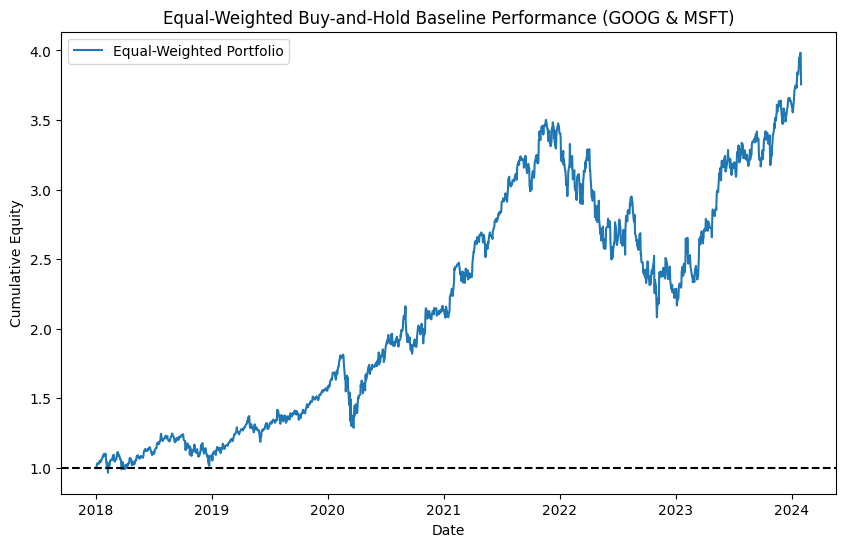

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------------
# SETTINGS & PARAMETERS
# -------------------------------
tickers = ["GOOG", "MSFT"]
start_date = "2018-01-01"
end_date   = "2024-02-01"

# -------------------------------
# DATA DOWNLOAD & PREPROCESSING
# -------------------------------
# Download historical data and use the adjusted close prices (auto_adjust=True makes it adjusted)
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
data.dropna(inplace=True)
prices = data['Close']  # Since prices are already adjusted

# -------------------------------
# CALCULATE DAILY RETURNS
# -------------------------------
# Compute daily percentage returns for each ticker
daily_returns = prices.pct_change().dropna()

# Create an equally weighted portfolio by taking the mean of returns across tickers
equal_weight_returns = daily_returns.mean(axis=1)

# -------------------------------
# COMPUTE EQUITY CURVE & PERFORMANCE METRICS
# -------------------------------
# Calculate the cumulative equity curve starting from 1
cumulative_equity = (1 + equal_weight_returns).cumprod()

# Total return over the period
total_return = cumulative_equity.iloc[-1] - 1

# Calculate the number of days in the sample period
days = (cumulative_equity.index[-1] - cumulative_equity.index[0]).days

# Annualized return using the cumulative equity
annualized_return = cumulative_equity.iloc[-1] ** (365.0 / days) - 1 if days > 30 else np.nan

# Annualized volatility based on daily returns (assume 252 trading days)
annualized_vol = equal_weight_returns.std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate is 0)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol > 0 else np.nan

# Calculate Sortino Ratio using downside volatility
downside_returns = equal_weight_returns[equal_weight_returns < 0]
if not downside_returns.empty:
    downside_vol = downside_returns.std() * np.sqrt(252)
else:
    downside_vol = np.nan
sortino_ratio = (annualized_return - risk_free_rate) / downside_vol if downside_vol and downside_vol > 0 else np.nan

# Calculate Maximum Drawdown
running_max = cumulative_equity.cummax()
drawdown = (cumulative_equity - running_max) / running_max
max_drawdown = drawdown.min()

# -------------------------------
# PRINT FINAL PERFORMANCE METRICS
# -------------------------------
print("--- Equal-Weighted Buy-and-Hold Baseline Performance ---")
print(f"Total Return: {total_return*100:.2f}%")
print(f"Annualized Return: {annualized_return*100:.2f}%")
print(f"Annualized Volatility: {annualized_vol*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown*100:.2f}%")

# -------------------------------
# PLOT EQUITY CURVE
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(cumulative_equity, label="Equal-Weighted Portfolio")
plt.axhline(1, color='black', linestyle='--')
plt.title("Equal-Weighted Buy-and-Hold Baseline Performance (GOOG & MSFT)")
plt.xlabel("Date")
plt.ylabel("Cumulative Equity")
plt.legend()
plt.show()


# <span style="font-size:36px; color:orange;">Out-of-Sample Test⬇️ </span>

[*********************100%***********************]  2 of 2 completed


⚠️ Johansen test (Training): GOOG & MSFT may NOT be cointegrated. (Continuing...)
✅ Hedge Ratio (from training): 0.7774

--- Training Optimization Results ---
Best Params: (90, 40, 0.1, 0.5, 0.1, 0.08, 1.5), Cost: 999.61
Training set best parameters:
Rolling Window: 90 days
Quantile Window: 40 days
Exit Threshold: 0.1
ATR Multiplier: 0.5
Max Drawdown Limit: 10.0%
Target Annual Volatility: 0.08
Max Leverage: 1.5


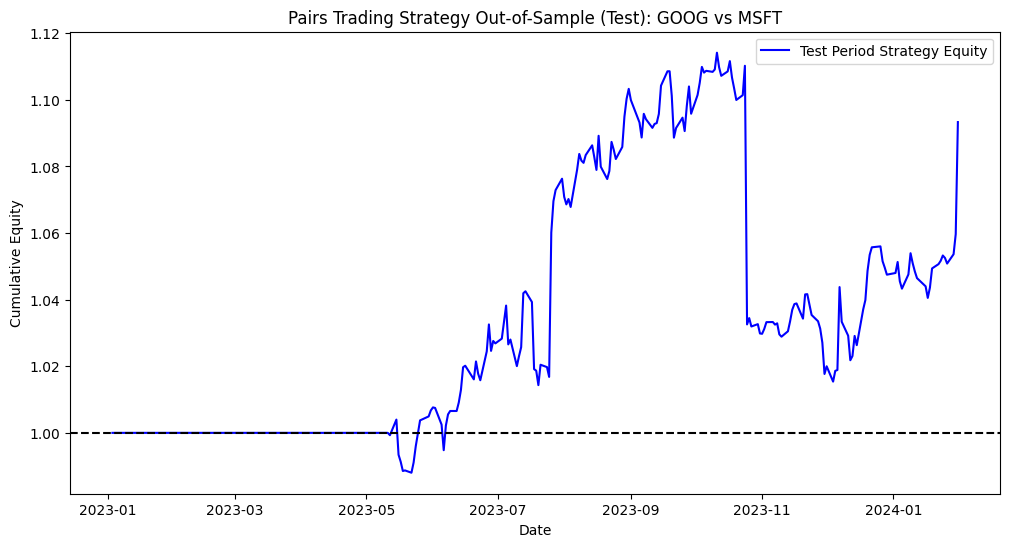


--- Test Performance Metrics ---
Total Return: 9.33%
Annualized Return: 8.64%
Annualized Volatility: 10.75%
Sharpe Ratio: 0.80
Sortino Ratio: 0.67
Max Drawdown: -8.87%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")
from itertools import product

np.random.seed(42)

# -----------------------------
# 1. SETTINGS & DATA DOWNLOAD
# -----------------------------
ticker1 = "GOOG"
ticker2 = "MSFT"
tickers = [ticker1, ticker2]

# 定義整個資料下載的日期範圍（包含訓練與測試）
start_date = "2018-01-01"
end_date   = "2024-02-01"

# 定義訓練與測試集的日期範圍
train_start = "2018-01-01"
train_end   = "2022-12-31"
test_start  = "2023-01-01"
test_end    = end_date

def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
    if data.empty:
        raise ValueError("No data downloaded. Check tickers or date range.")
    return data

# 下載完整資料
data_full = download_data(tickers, start_date, end_date)
df_adj_full = data_full['Adj Close'].dropna()

# 根據日期分割為訓練集與測試集
df_adj_train = df_adj_full.loc[train_start:train_end]
df_adj_test  = df_adj_full.loc[test_start:test_end]

# 以自然對數轉換
log_df_train = np.log(df_adj_train)
log_df_test  = np.log(df_adj_test)

# -----------------------------
# 2. ATR 計算
# -----------------------------
def compute_atr(high, low, close, window=14):
    tr = pd.concat([high - low,
                    (high - close.shift(1)).abs(),
                    (low - close.shift(1)).abs()], axis=1).max(axis=1)
    return tr.rolling(window).mean()

# 訓練集 ATR：根據訓練資料的 High、Low、Close
atr1_train = compute_atr(data_full['High'][ticker1].loc[train_start:train_end],
                         data_full['Low'][ticker1].loc[train_start:train_end],
                         data_full['Close'][ticker1].loc[train_start:train_end], window=14)
atr2_train = compute_atr(data_full['High'][ticker2].loc[train_start:train_end],
                         data_full['Low'][ticker2].loc[train_start:train_end],
                         data_full['Close'][ticker2].loc[train_start:train_end], window=14)
avg_atr_train = (atr1_train + atr2_train) / 2
avg_price_train = df_adj_train.mean().mean()
global_atr_pct_train = avg_atr_train.mean() / avg_price_train

# 對測試集也同理計算 ATR（用測試期資料）
atr1_test = compute_atr(data_full['High'][ticker1].loc[test_start:test_end],
                        data_full['Low'][ticker1].loc[test_start:test_end],
                        data_full['Close'][ticker1].loc[test_start:test_end], window=14)
atr2_test = compute_atr(data_full['High'][ticker2].loc[test_start:test_end],
                        data_full['Low'][ticker2].loc[test_start:test_end],
                        data_full['Close'][ticker2].loc[test_start:test_end], window=14)
avg_atr_test = (atr1_test + atr2_test) / 2
avg_price_test = df_adj_test.mean().mean()
global_atr_pct_test = avg_atr_test.mean() / avg_price_test

# -----------------------------
# 3. 協整檢定與對沖比率（僅用訓練集）
# -----------------------------
def johansen_test(log_prices):
    result = coint_johansen(log_prices, det_order=-1, k_ar_diff=1)
    # 利用 5% 臨界值比較 trace 統計量
    return result.lr1[0] > result.cvt[0, 1]

if johansen_test(log_df_train[[ticker1, ticker2]]):
    print(f"✅ Johansen test (Training): {ticker1} & {ticker2} appear cointegrated.")
else:
    print(f"⚠️ Johansen test (Training): {ticker1} & {ticker2} may NOT be cointegrated. (Continuing...)")

def compute_hedge_ratio(log_prices, tkrA, tkrB):
    # 回歸 tkrA 對 tkrB，回歸係數作為對沖比率
    return sm.OLS(log_prices[tkrA], sm.add_constant(log_prices[tkrB])).fit().params[tkrB]

hedge_ratio = compute_hedge_ratio(log_df_train, ticker1, ticker2)
print(f"✅ Hedge Ratio (from training): {hedge_ratio:.4f}")

def compute_spread(log_prices, tkrA, tkrB, hr):
    return log_prices[tkrA] - hr * log_prices[tkrB]

# 訓練集的價差
spread_train = compute_spread(log_df_train, ticker1, ticker2, hedge_ratio)
# 測試集的價差 (使用同一對沖比率)
spread_test = compute_spread(log_df_test, ticker1, ticker2, hedge_ratio)

# -----------------------------
# 4. 策略模擬函數（調整：傳入 atr_pct 參數）
# -----------------------------
def simulate_strategy(df_prices, spread, hedge_ratio, rolling_window, quantile_window,
                      exit_threshold, atr_multiplier, max_drawdown_limit,
                      cost_per_trade, target_vol, max_leverage, atr_pct):
    """
    模擬策略運行，參數說明：
      - df_prices: 價格資料（Adj Close）
      - spread: 價差序列（對數價格差）
      - hedge_ratio: 對沖比率
      - rolling_window: 滾動均值/標準差視窗
      - quantile_window: 分位數閾值視窗
      - exit_threshold: 退出信號 z-score 閾值
      - atr_multiplier: ATR 止損倍率
      - max_drawdown_limit: 最大回撤限制（如 0.1 代表 10%）
      - cost_per_trade: 每次換倉的成本（滑點+傭金）
      - target_vol: 目標年化波動率（例如 0.10 為 10%）
      - max_leverage: 最大槓桿倍數
      - atr_pct: 用於止損的全域 ATR 百分比（依據當期資料計算）
    """
    # 1) 計算滾動統計值、z-score
    roll_mean = spread.rolling(rolling_window).mean()
    roll_std  = spread.rolling(rolling_window).std()
    z_score   = (spread - roll_mean) / roll_std

    # 2) 自適應閾值設定：利用滾動分位數
    upper_q = z_score.rolling(quantile_window).quantile(0.75).bfill()
    lower_q = z_score.rolling(quantile_window).quantile(0.25).bfill()

    # 3) ATR 止損門檻（轉為百分比）
    atr_stop_loss = atr_multiplier * atr_pct

    # 4) 市場波動性過濾：計算每天兩檔股票的百分比變化標準差均值
    overall_vol = df_prices.pct_change().rolling(21).std().mean(axis=1)
    vol_filter_threshold = 0.02  # 當日波動超過 2% 則跳過新倉進入

    # 5) 動態槓桿調整：目標日波動率
    target_daily_vol = target_vol / np.sqrt(252)
    asset_returns = df_prices.pct_change().fillna(0)
    daily_spread_ret_series = asset_returns[ticker1] - hedge_ratio * asset_returns[ticker2]
    rolling_spread_std = daily_spread_ret_series.rolling(30, min_periods=30).std().bfill()
    dynamic_leverage = (target_daily_vol / rolling_spread_std).clip(0.5, max_leverage)

    dates = df_prices.index
    n = len(dates)
    positions = np.zeros(n)    # +1: long spread, -1: short spread, 0: flat
    pos_sizes = np.zeros(n)    # 根據動態槓桿調整的頭寸大小
    strat_returns = np.zeros(n)
    equity_curve = np.zeros(n)
    equity = 1.0
    equity_curve[0] = equity
    current_pos = 0
    current_max = equity

    # 記錄每筆交易進場時的 equity（用於止損計算）
    entry_equity = None

    for i in range(1, n):
        current_max = max(current_max, equity_curve[i-1])
        if equity_curve[i-1] < (1 - max_drawdown_limit) * current_max:
            current_pos = 0
            entry_equity = None

        # 信號生成與風險管控
        if current_pos == 0:
            if overall_vol.iloc[i] > vol_filter_threshold:
                new_pos = 0  # 高波動性時不進場
            else:
                if z_score.iloc[i] < lower_q.iloc[i]:
                    new_pos = 1  # 進行多頭操作（long spread）
                    entry_equity = equity
                elif z_score.iloc[i] > upper_q.iloc[i]:
                    new_pos = -1 # 進行空頭操作（short spread）
                    entry_equity = equity
                else:
                    new_pos = 0
        else:
            # 如果持倉中，檢查止損
            if entry_equity is not None and equity < entry_equity * (1 - atr_stop_loss):
                new_pos = 0  # 觸及止損平倉
                entry_equity = None
            else:
                new_pos = current_pos if abs(z_score.iloc[i]) >= exit_threshold else 0
                if new_pos == 0:
                    entry_equity = None

        # 計算換倉成本
        transaction_cost = cost_per_trade * abs(new_pos - current_pos)
        positions[i] = new_pos
        pos_sizes[i] = new_pos * dynamic_leverage.iloc[i]

        daily_spread_ret = asset_returns[ticker1].iloc[i] - hedge_ratio * asset_returns[ticker2].iloc[i]
        daily_strat_ret = pos_sizes[i-1] * daily_spread_ret - transaction_cost

        equity *= (1 + daily_strat_ret)
        equity_curve[i] = equity
        strat_returns[i] = daily_strat_ret
        current_pos = new_pos

    equity_curve = pd.Series(equity_curve, index=dates)
    strat_returns = pd.Series(strat_returns, index=dates)
    days = (dates[-1] - dates[0]).days
    total_return = equity_curve.iloc[-1] - 1
    annualized_return = (equity_curve.iloc[-1]) ** (365.0 / days) - 1 if days > 30 else np.nan
    equity_daily_ret = equity_curve.pct_change().fillna(0)
    ann_vol = equity_daily_ret.std() * np.sqrt(252)
    sharpe = annualized_return / ann_vol if ann_vol > 0 else np.nan
    downside_vol = equity_daily_ret[equity_daily_ret < 0].std() * np.sqrt(252)
    sortino = annualized_return / downside_vol if downside_vol > 0 else np.nan
    dd_series = equity_curve / equity_curve.cummax() - 1
    max_dd = dd_series.min()

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_vol': ann_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_dd
    }
    
    return equity_curve, strat_returns, positions, metrics

# -----------------------------
# 5. 參數優化（以 Grid Search 為例，在訓練集上進行）
# -----------------------------
# 固定部分參數：交易成本（固定值）
slippage   = 0.0005  # 0.05%
commission = 0.0002  # 0.02%
cost_per_trade = slippage + commission

def objective(params):
    """
    優化目標函數，參數順序：
      rw: 滾動窗口
      qw: 分位數窗口
      et: 退出閾值
      am: ATR 乘數
      dl: 最大回撤限制
      tv: 目標年化波動率
      ml: 最大槓桿
    """
    rw, qw, et, am, dl, tv, ml = params
    eq_curve, _, _, metrics = simulate_strategy(
        df_prices=df_adj_train,
        spread=spread_train,
        hedge_ratio=hedge_ratio,
        rolling_window=rw,
        quantile_window=qw,
        exit_threshold=et,
        atr_multiplier=am,
        max_drawdown_limit=dl,
        cost_per_trade=cost_per_trade,
        target_vol=tv,
        max_leverage=ml,
        atr_pct=global_atr_pct_train
    )
    sharpe = metrics['sharpe_ratio']
    total_ret = metrics['total_return']
    cost_value = -sharpe if total_ret >= 0.20 else -sharpe + 1000
    return cost_value

def grid_search():
    rolling_windows  = [30, 60, 90]
    quantile_windows = [20, 30, 40]
    exit_thresholds  = [0.1, 0.15, 0.2]
    atr_multipliers  = [0.25, 0.5, 1.0]
    drawdown_limits  = [0.05, 0.1]
    target_vols      = [0.08, 0.10, 0.12]
    max_leverages    = [1.5, 2.0, 3.0]
    
    best_cost = float('inf')
    best_params = None
    for params in product(rolling_windows, quantile_windows, exit_thresholds,
                          atr_multipliers, drawdown_limits, target_vols, max_leverages):
        cost = objective(params)
        if cost < best_cost:
            best_cost = cost
            best_params = params
    return best_params, best_cost

grid_best, grid_cost = grid_search()

print("\n--- Training Optimization Results ---")
print(f"Best Params: {grid_best}, Cost: {grid_cost:.2f}")
print(f"Training set best parameters:")
print(f"Rolling Window: {grid_best[0]} days")
print(f"Quantile Window: {grid_best[1]} days")
print(f"Exit Threshold: {grid_best[2]}")
print(f"ATR Multiplier: {grid_best[3]}")
print(f"Max Drawdown Limit: {grid_best[4]*100:.1f}%")
print(f"Target Annual Volatility: {grid_best[5]}")
print(f"Max Leverage: {grid_best[6]}")

# -----------------------------
# 6. 在測試集上進行最終回測（Out-of-Sample）
# -----------------------------
final_equity_test, final_returns_test, final_positions_test, final_metrics_test = simulate_strategy(
    df_prices=df_adj_test,
    spread=spread_test,
    hedge_ratio=hedge_ratio,
    rolling_window=grid_best[0],
    quantile_window=grid_best[1],
    exit_threshold=grid_best[2],
    atr_multiplier=grid_best[3],
    max_drawdown_limit=grid_best[4],
    cost_per_trade=cost_per_trade,
    target_vol=grid_best[5],
    max_leverage=grid_best[6],
    atr_pct=global_atr_pct_test
)

plt.figure(figsize=(12, 6))
plt.plot(final_equity_test, label="Test Period Strategy Equity", color='blue')
plt.axhline(1.0, color='black', linestyle='--')
plt.title(f"Pairs Trading Strategy Out-of-Sample (Test): {ticker1} vs {ticker2}")
plt.xlabel("Date")
plt.ylabel("Cumulative Equity")
plt.legend()
plt.show()

print("\n--- Test Performance Metrics ---")
print(f"Total Return: {final_metrics_test['total_return']:.2%}")
print(f"Annualized Return: {final_metrics_test['annualized_return']:.2%}")
print(f"Annualized Volatility: {final_metrics_test['annualized_vol']:.2%}")
print(f"Sharpe Ratio: {final_metrics_test['sharpe_ratio']:.2f}")
print(f"Sortino Ratio: {final_metrics_test['sortino_ratio']:.2f}")
print(f"Max Drawdown: {final_metrics_test['max_drawdown']:.2%}")
